In [18]:
from datasets import load_dataset

# Load only the first 300 training examples
dataset = load_dataset("neural-bridge/rag-dataset-12000", split='train[:300]')

Generating train split:   0%|          | 0/9600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2400 [00:00<?, ? examples/s]

In [5]:
import plotly.graph_objects as go
import networkx as nx
import numpy as np
from dash import Dash, dcc, html, Input, Output, State, callback
import pandas as pd
import plotly.express as px

network_data = np.load('nn_graph.npz', allow_pickle=True)


def create_graph_from_array(network_data):
    # Initialize an empty graph
    G = nx.Graph()
    
    # Get the number of nodes
    n_nodes = network_data.shape[0]
    
    # Add nodes and edges to the graph
    for node in range(n_nodes):
        for neighbor in network_data[node, :]:
            # Add an edge between the node and its neighbor
            G.add_edge(node, neighbor)

    pos = nx.spring_layout(G)

    for node, position in pos.items():
        G.nodes[node]['pos'] = position
    
    return G

G = create_graph_from_array(network_data)

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_to_highlight = 50

node_x = []
node_y = []
node_size = []
n_nodes = len(G.nodes())
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_size.append(10) 

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_adjacencies = []
node_text = []

for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text
node_trace.marker.size = node_size


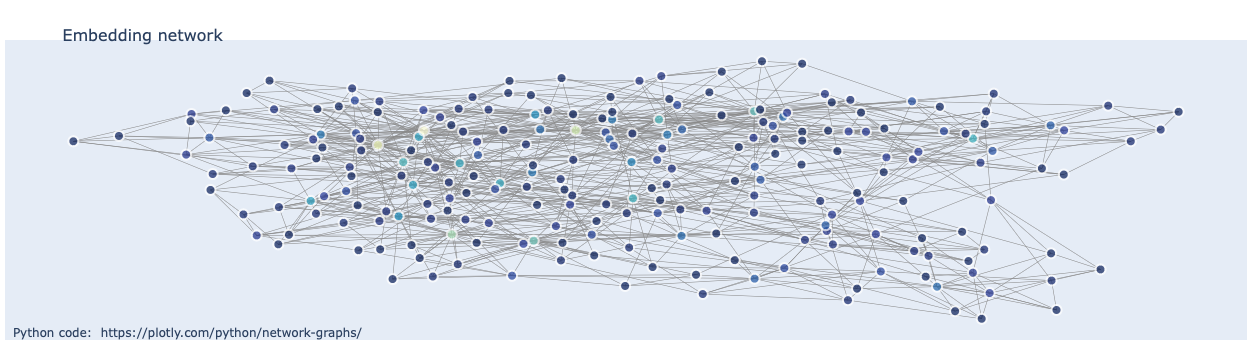

In [6]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Embedding network',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/python/network-graphs/'> https://plotly.com/python/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )


fig.show()

In [23]:


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = Dash(__name__, external_stylesheets=external_stylesheets)

df = pd.read_csv('https://plotly.github.io/datasets/country_indicators.csv')


app.layout = html.Div([
    html.Div([
        dcc.Input(id='input-box', type='text', style={'width': '80%'}),
        html.Button('Submit', id='input-button', style={'display': 'inline-block', 'marginLeft': '10px'})
    ], style={'width': '70%', 'display': 'flex', 'alignItems': 'center'}),

    html.Div([
        dcc.Graph(
            id='network-graph',
            hoverData={'points': [{'customdata': 'Japan'}]}
        )
    ], style={'width': '70%', 'display': 'inline-block', 'height': 'calc(100vh - 80px)'}),
    html.Div([
    dcc.Textarea(
        id='output-textbox', 
        value='', 
        readOnly=True, 
        style={'width': '100%', 'height': '100%', 'resize': 'none'}
    )
], style={'width': '30%', 'display': 'inline-block', 'verticalAlign': 'top', 'height': 'calc(100vh - 80px)'})
])


@callback(
    Output('network-graph', 'figure'),
    Output('output-textbox', 'value'),
    Input('input-button', 'n_clicks'),
    State('input-box', 'value'))
def update_graph(click, node_id):
    node_text = ''
    sizes = [10] * len(node_trace.marker.size)
    if (click is not None) and (click>0):
        if node_id:
            node_id = int(node_id)
            node_text = dataset[node_id]['context']
            if (node_id < n_nodes) & (node_id >= 0):
                sizes[int(node_id)] = 40
    node_trace.marker.size = sizes
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/python/network-graphs/'> https://plotly.com/python/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
    
    return fig, node_text




app.run(debug=True)



In [25]:

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = Dash(__name__, external_stylesheets=external_stylesheets)

df = pd.read_csv('https://plotly.github.io/datasets/country_indicators.csv')


app.layout = html.Div([
    html.Div([
        dcc.Input(id='input-box', type='text', style={'width': '80%'}),
        html.Button('Submit', id='input-button', style={'display': 'inline-block', 'marginLeft': '10px'})
    ], style={'width': '70%', 'display': 'flex', 'alignItems': 'center'}),

    html.Div([
        dcc.Graph(
            id='network-graph',
            hoverData={'points': [{'customdata': 'Japan'}]}
        )
    ], style={'width': '70%', 'display': 'inline-block', 'height': 'calc(100vh - 80px)'}),
    html.Div([
    dcc.Textarea(
        id='output-textbox', 
        value='', 
        readOnly=True, 
        style={'width': '100%', 'height': '100%', 'resize': 'none'}
    )
], style={'width': '30%', 'display': 'inline-block', 'verticalAlign': 'top', 'height': 'calc(100vh - 80px)'})
])


@callback(
    Output('network-graph', 'figure'),
    Output('output-textbox', 'value'),
    Input('network-graph', 'clickData'),
    Input('input-button', 'n_clicks'),
    State('input-box', 'value'))
def update_graph(clickData, click, node_id):
    node_text = ''
    sizes = [10] * len(node_trace.marker.size)

    if clickData:
        clicked_node = clickData['points'][0]['pointIndex']
        node_id = clicked_node
        click = 1
    
    
    if (click is not None) and (click>0):
        if node_id:
            node_id = int(node_id)
            node_text = dataset[node_id]['context']
            if (node_id < n_nodes) & (node_id >= 0):
                sizes[int(node_id)] = 40
    node_trace.marker.size = sizes
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/python/network-graphs/'> https://plotly.com/python/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
    
    return fig, node_text




app.run(debug=True)

